<a href="https://colab.research.google.com/github/DurdenTyler2008/University-of-AI/blob/main/%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81_%D0%BF%D0%BE%D0%B4%D0%BA%D1%80%D0%B5%D0%BF%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Запустите нейросеть на разном количестве тренировок, сравните результаты:

- 10 тренировок - количество выигранных очков?
- 20 тренировок - количество выигранных очков?
- 30 тренировок - количество выигранных очков?
## 2. Проведите небольшую тренировочную сессию, изменив архитектуру нейросети:

- изменив количество связей в Dense слое,
- добавив Dense слой,
- добавив Conv слой.

In [ ]:
!pip install tensorflow==1.15 -q

In [ ]:
pip install keras==2.3 -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import gym               #"тренажер" Gym из платформы OpenAi, предоставляющий среду для работы над обучением с подкреплением 
import numpy as np 
import keras       
from keras.models import Model, load_model 
from keras.layers import Dense, Flatten, Input, Lambda, Conv2D, MaxPooling2D, Reshape, Multiply 
from keras.optimizers import RMSprop, Adam 
import time                                
import matplotlib.pyplot as plt            #библиотекa для визуализации данных

%matplotlib inline

## View:




In [ ]:
env = gym.make('Pong-v0')                  # создаем среду игры Понг средствами OpenAI Gym('env' = environment)
observation = env.reset()                  # задаем начальное состояние среды, которое наблюдает агент
print("формa состояния среды:", observation.shape)         
                          

формa состояния среды: (210, 160, 3)


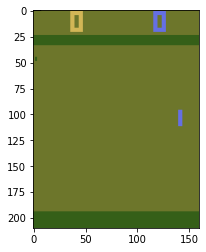

In [ ]:
plt.imshow(observation)                   # визуализация состояния среды с помощью метода imshow от matplotlib.pyplot
plt.show() 

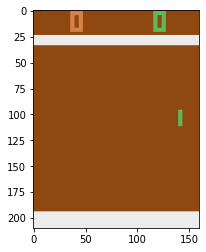

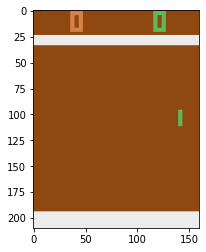

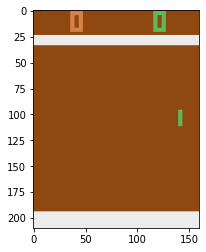

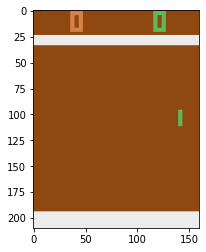

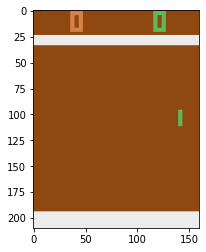

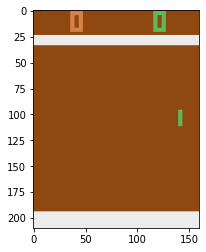

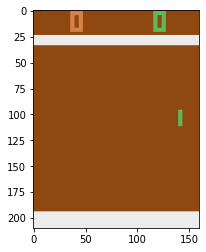

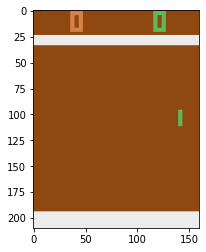

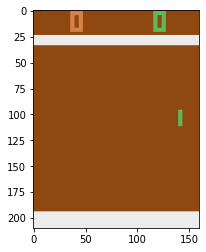

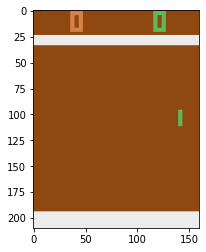

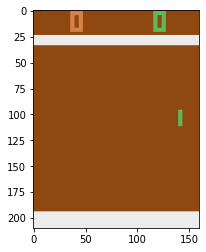

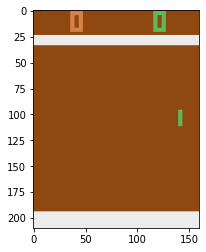

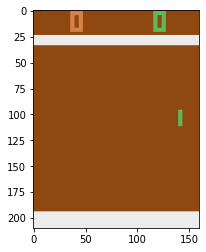

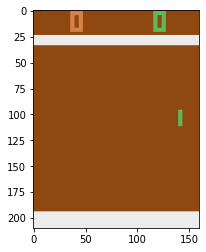

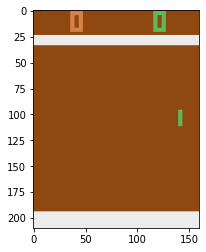

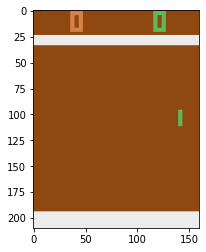

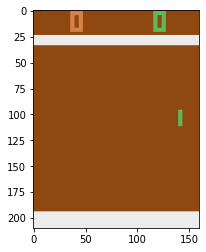

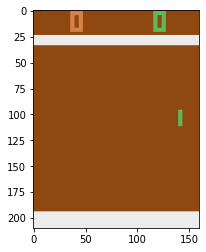

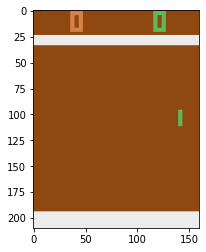

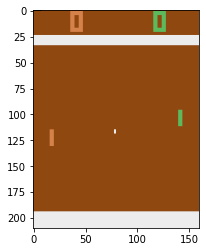

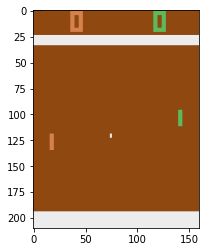

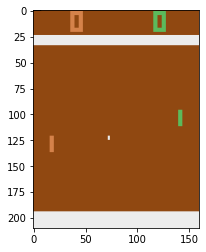

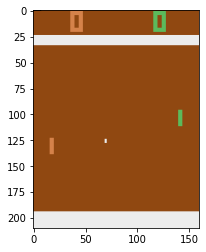

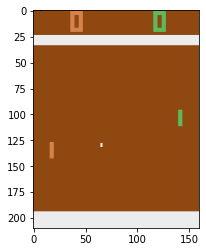

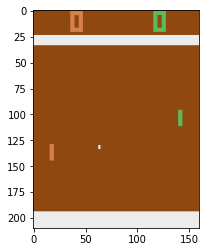

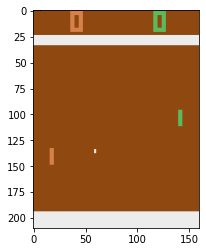

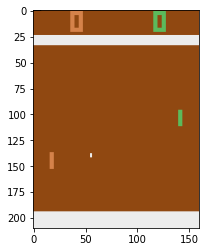

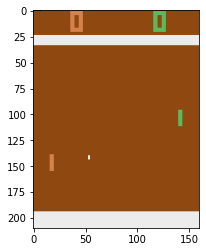

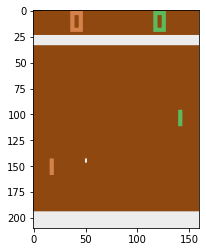

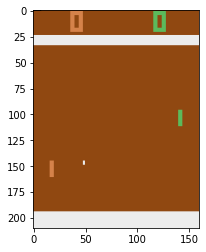

'\n  step - такт, шаг в игре: принимает (action, действие агента), возвращает кортеж (observation, reward, done, info)\n  observation (object) - текущее состояние среды, которое наблюдает агент(пиксели)\n  reward (float) - награда за совершённое действие\n  done (True or False) - обозначает завершился ли игровой эпизод (в понге до победы 21 очко)\n  info (dict) - вспомогательная диагностическая информация, типа кол-во оставшихся жизней(неактуально для понга)\n'

In [ ]:
""""
  В понге:
  0 цифровое обозначение если ракетка 'остаётся на месте'
  2 цифровое обозначение для действия ракеткой 'сдвинуться вверх'
  3 цифровое обозначение для действия ракеткой 'сдвинуться вниз'
"""
# Проиграю вперёд игру на 30 кадров чтобы увидеть полную сцену игры
for i in range(30):
  
    observation, reward, done, info = env.step(0)    # 0 обозначает,что ничего не делаем, остаемся на месте
    plt.imshow(observation)                          # текущее состояние среды: наш агент владеет зелёной ракеткой, появился соперник и мяч
    plt.show()
"""
  step - такт, шаг в игре: принимает (action, действие агента), возвращает кортеж (observation, reward, done, info)
  observation (object) - текущее состояние среды, которое наблюдает агент(пиксели)
  reward (float) - награда за совершённое действие
  done (True or False) - обозначает завершился ли игровой эпизод (в понге до победы 21 очко)
  info (dict) - вспомогательная диагностическая информация, типа кол-во оставшихся жизней(неактуально для понга)
"""

###Policy(политику, стратегию агента) будет позже задавать нейросеть.
Подадим ей разницу между новым и предыдущим кадром, чтобы отслеживалось смещение мяча/ракеток и данные были понятными

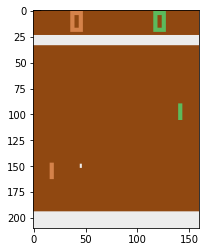

In [ ]:
newObservation, reward, done, info = env.step(2)   # задаем очередным шагом следующий кадр, при этом смещая ракетку вверх
plt.imshow(newObservation)                         # взглянем на следующий кадр(нам смещение едва видно, либо не видно, т.к визуально длина шага мала)

## Функция предобработки данных для подачи в нейросеть:
###оставляю на экране лишь мяч и ракетки


In [ ]:
def preprocessFrames(newFrame, lastFrame): # подаем в функцию новый и предыдущий кадр

    nFrame = newFrame.astype(np.int32)      # переводим в целочисленный тип новый кадр
    nFrame[nFrame==144] = 0                 # удаляем цвета заднего фона в новом кадре(144 и 72 - значения каналов, дающих оранжевый цвет, зануляем)
    nFrame[nFrame==72] = 0                  # удаляем цвета заднего фона в новом кадре(144 и 72 - значения каналов, дающих оранжевый цвет, зануляем)  
    lFrame = lastFrame.astype(np.int32)     # переводим в целочисленный тип предыдущий кадр
    lFrame[lFrame==144] = 0                 # удаляем цвета заднего фона в новом кадре(144 и 72 - значения каналов, дающих оранжевый цвет, зануляем)
    lFrame[lFrame==72] = 0                  # удаляем цвета заднего фона в новом кадре(144 и 72 - значения каналов, дающих оранжевый цвет, зануляем)  
    deltaFrame = nFrame - lFrame            # задаём разницу между новым и предыдущим кадром 
     
    # Отрезаем верхнюю и нижнюю(неинформативные) части экрана, по 35 сверху и снизу
    deltaFrame = deltaFrame[35:195]         # срезали края по высоте, осталась картинка 160*160
    # Делаем сжатие кадра в 2 раза по обеим сторонам изображения и оставляем монотонный канал 
    deltaFrame=deltaFrame[::2,::2, 0]
    # Масштабирование чисел от 0 до 1
    maxValue = deltaFrame.max() if deltaFrame.max()> abs(deltaFrame.min()) else abs(deltaFrame.min())
    if maxValue != 0:
        deltaFrame=deltaFrame/maxValue
    return deltaFrame                       # функция вернет разницу между кадрами в оптимальном виде

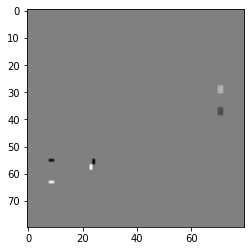

In [ ]:
plt.imshow(preprocessFrames(newObservation, observation), plt.cm.gray)  # выведем результат предобработки наших кадров

# смещение здесь - это шаг от черного пикселя к светлому

In [ ]:
preprocessFrames(newObservation, observation)         # выведем массив для этого состояния среды(кадра)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
print("формa массива:", preprocessFrames(newObservation, observation).shape)  

формa массива: (80, 80)


In [ ]:
"""
  Cостоянием среды будет картинка 80*80, полученная вычитанием двух последовательных кадров, где по итогу все будет 
  заполнено нулями, а в местах смещения мяча либо ракетки - ненулевые значения.
  Далее keras'ом создадим policy, которая на основе состояния(картинки) выбирает действия.
  Output сети - вероятность того что нужно двигаться вверх
"""

## Mоделирую нейросеть:


In [ ]:

inputs = Input(shape=(80,80))                                                       # на входе изображение 80*80

flattenedLayer = Flatten()(inputs)                                                  # в вектор
fullConnected = Dense(200, activation="relu", use_bias=False)(flattenedLayer)       # задали 200 нейронов и активацию релу
sigmoidOutput = Dense(1, activation="sigmoid", use_bias=False)(fullConnected)       # сигмоида на выходе
policyNetworkModel = Model(inputs=inputs, outputs=sigmoidOutput)                    # собрали модель стратегии(Model - абстрактный класс базовой модели)


In [ ]:
policyNetworkModel.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 80, 80)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 200)               1280000   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 200       
Total params: 1,280,200
Trainable params: 1,280,200
Non-trainable params: 0
_________________________________________________________________


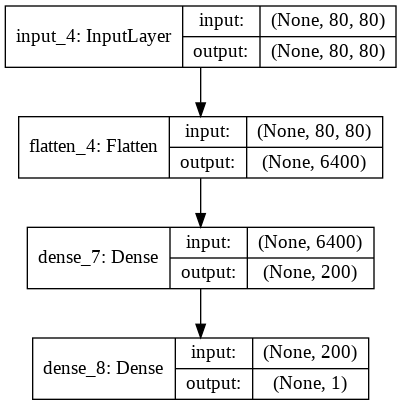

In [ ]:
from keras.utils import plot_model

plot_model(policyNetworkModel, show_shapes=True, show_layer_names=True)

##Cоздаю функцию потерь в соответствии с вознаграждением
####episode - одна тренировочная игра от начала партии до перезагрузки (розыгрыш эпизода до 21 очка; после победы или поражения вызываю reset)


In [ ]:
episodeReward = Input(shape=(1,), name='episodeReward')       # наградa за эпизод

In [ ]:
"""
  Функция потерь в керасе имеет вид def loss(yTrue,yPred):...А так как нам нужно включить reward в loss, создаю
  функцию rewardedLoss поверх неё, чтобы на входе добавить episodeReward
"""

In [ ]:
def rewardedLoss(episodeReward):            # задаем новую функцию потерь, принимающую episodeReward(награда)

  def loss(yTrue,yPred):
      """
        подаю в кач-ве yTrue фактически сделанное действие(action) 
        если фактически сделанное действие было движением вверх - подаю 1 на yTrue, если нет то подаю 0
        yPred - выход сетки(вероятность выбора движения вверх)
        мы не подаём yPred в нейронку, его вычисляет керас
      """
      # сначала log(0) and log(1) неопределены - загоняем yPred между значениями:
      tmpPred = Lambda(lambda x: keras.backend.clip(x,0.05,0.95))(yPred)
      """
        вычисляем логарифм вероятности. yPred - вероятность выбора движения вверх 
        помним что yTrue = 1 когда фактически выбрано движение вверх, и 0 - когда вниз
        формула похожа на кросс-энтропию в керасе, но здесь мы прописываем её вручную, чтобы умножить на значение награды
      """
      tmpLoss = Lambda(lambda x:-yTrue*keras.backend.log(x)-(1-yTrue)*(keras.backend.log(1-x)))(tmpPred)
      # обновленная функция потерь - "функция политики"
      policyLoss = Multiply()([tmpLoss, episodeReward]) #добавляем в loss умножение на награду за эпизод
      return policyLoss # ввели обновленную функцию политики
  return loss         # возвращаем обновленную функцию политики

## керас-оптимизатор и нейро-сеть для обучения:

In [ ]:
episodeReward = Input(shape=(1,), name='episodeReward')                             # задаем награду за эпизод
policyNetworkTrain = Model(inputs=[inputs, episodeReward],outputs=sigmoidOutput)    # задаем сеть с добавлением на вход награды
 
myOptimizer = RMSprop(lr=0.0001)                                                    # выбрали оптимизатор с заданной скоростью обучения
policyNetworkTrain.compile(optimizer=myOptimizer, loss=rewardedLoss(episodeReward)) # задаем сеть с новой функцией потерь policy

##Генерирую игровой эпизод с участием нейросети:



In [ ]:
#игра начнется с того, что в новом эпизоде наш агент сделает движение("actualAction") вверх с вероятностью(upProbability), которую предсказала наша...
#...сетка policyNetwork, принявшая на вход состояние среды reshapedInput с подбитой под сеть формой. 
#reshapedInput же получили из состояния processedNetworkInput, которое представляет собой разницу в кадрах между новым и предыдущим...
#...кадром, полученную функцией preprocessFrames.
 
 
def generateEpisode(policyNetwork): # подаем на вход функции модель нейросети
  statesList = []                   # список состояний в течение эпизода, размер = (x,80,80)
  upDownActionList=[]               # список движений в течение эпизода: вверх - 1, вниз - 0
  rewardsList=[]                    # список наград за каждое действие
  networkOutputList=[]              # на выходе нейросети - вероятность что нужно идти вверх; собираем список из вероятности на каждом шаге
  env = gym.make("Pong-v0")           # cоздали среду
  observation = env.reset()         # перезагрузили состояние среды
  newObservation = observation      # получили новое состояние, которое наблюдает агент
  done = False                      # игровой эпизод активен(не завершён)
 
  while done == False: # пока игровой эпизод не завершён
    # На вход сети будет подаваться очередное состояние - разница между кадрами. 
    processedNetworkInput = preprocessFrames(newFrame=newObservation, lastFrame=observation) # зададим это состояние
    statesList.append(processedNetworkInput) # добавим в список состояний (впоследствие станет 'x'ом для входа в нейронку)
    reshapedInput = np.expand_dims(processedNetworkInput, axis=0) # размер 'x' - (80,80), делаем размерность (x,(1,80,80))
 
    upProbability = policyNetwork.predict(reshapedInput, batch_size=1)[0][0] # задаем вероятность шага вверх
    
    networkOutputList.append(upProbability) # добавляем к списку из вероятности идти вверх на каждом шаге
    actualAction = np.random.choice(a=[2,3], size=1, p=[upProbability, 1-upProbability])
    # сделаем фактический шаг либо вверх(2) c вероятностью upProbability, либо вниз(3) с обратной вероятностью
 
    if actualAction == 2:        # если пошли вверх
      upDownActionList.append(1) # добавляем единицу в список движений в течение эпизода
    else:                        # если не пошли вверх
      upDownActionList.append(0) # то добавляем ноль
 
    observation = newObservation # текущий newObservation записываем как старый перед тем, как сделать следующий шаг
    newObservation, reward, done, info = env.step(actualAction) # сделали новый шаг, получили новую награду, новое состояние
 
    rewardsList.append(reward)   # добавили текущую награду в список
 
    if done: # если игровой эпизод закончен
      break  # завершаем цикл
 
  env.close() # закрываем текущую среду
  return statesList, upDownActionList, rewardsList, networkOutputList
  # функция возвращает: список состояний в течение эпизода,список движений в течение эпизода, список наград за каждое действие,
  # и список вероятностей того, что нужно идти вверх

###Генерирую эпизод игры с необученной сетью:

In [ ]:
statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(policyNetworkModel)
print("Количество состояний в эпизоде = "+str(len(statesList))) # количество состояний (кадров) в эпизоде
print("Форма состояния "+str(statesList[0].shape))              # форма каждого состояния
print("Количество наград за эпизод = "+str(len(rewardsList)))   # количество наград за эпизод(включая нулевые награды)

Количество состояний в эпизоде = 1347
Форма состояния (80, 80)
Количество наград за эпизод = 1347


In [ ]:
statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(policyNetworkModel)
print("Количество состояний в эпизоде = "+str(len(statesList))) # количество состояний (кадров) в эпизоде
print("Форма состояния "+str(statesList[0].shape))              # форма каждого состояния
print("Количество наград за эпизод = "+str(len(rewardsList)))   # количество наград за эпизод(включая нулевые награды)

Количество состояний в эпизоде = 1097
Форма состояния (80, 80)
Количество наград за эпизод = 1097


In [ ]:
# Фактические действия: 1 - вверх, 0 - вниз
print(upDownActionList[50:70])
print("шаги также были случайными")

[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]
шаги также были случайными


In [ ]:
print("список наград:", rewardsList[50:70])

список наград: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


###Количество игр в эпизоде:

In [ ]:
print("Количество выигранных очков = "+str(len(list(filter(lambda r: r > 0, rewardsList)))))   # берем как длину списка, отфильтрованного по наградам,большим 0
print("Количество проигранных очков = "+str(len(list(filter(lambda r: r < 0, rewardsList)))))  # берем как длину списка, отфильтрованного по наградам,меньшим 0
print("Количество нулевых наград = "+str(len(list(filter(lambda r: r == 0, rewardsList)))))    #с фильтром по 0

Количество выигранных очков = 0
Количество проигранных очков = 21
Количество нулевых наград = 1308


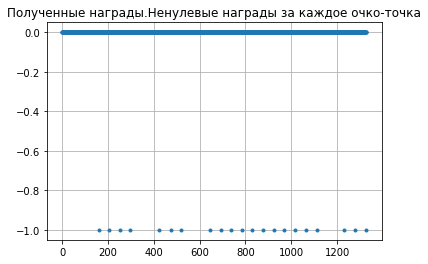

In [ ]:
plt.plot(rewardsList, '.') # точки будут наградами на графике
plt.title("Полученные награды.Ненулевые награды за каждое очко-точка")
ax=plt.gca()               # получим текущие оси
ax.grid(True)              # с фоновой сеткой

## Эффективно определяею вознаграждение:



In [ ]:
# Награды пока присуждаются только тем движениям, в момент после которых было пропущено или забито очко. Но так мы научимся нескоро,
# нам нужно указать на важность действия чуть ранее, когда мы отбивали мяч ракеткой. Чтобы сетка поняла что отбивать мяч - это хорошо,
# распределим награду на все шаги, предшествующие забитому/пропущеному мячу, причем чем давнее был шаг, тем меньший коэффициент награды он получит.
 
###########################
# Сформулируем функцию, которая распределит ненулевую награду для всех шагов в удачном/неудачном розыгрыше
###########################
def processRewards(rewardList): # подадим в функцию список наград
    rewardDecay = 0.99            # установим высший коэффициент награды для ближнего действия к победному/проигрышному действию
    tmpReward = 0                 # создадим временную переменную для награды
    rewardDecayed = np.zeros_like(rewardList,dtype=np.float32) # создадим массив из нулей для нового формата наград

    for i in range(len(rewardList)-1, -1, -1): # будем идти в обратную сторону от награды с шагом "-1"
      if rewardList[i] == 0:                 # если награда нулевая 
        tmpReward = tmpReward*rewardDecay    # зададим ей коэффициент
        rewardDecayed[i] = tmpReward         # и добавим в массив
      else:                                  # иначе
        tmpReward = rewardList[i]            # оставим награду неизменной
        rewardDecayed[i] = tmpReward         # и введём в том же виде в массив
        
    # запустим нормализацию значений наград, что позволит сетке лучше понимать, где были хорошие и плохие шаги
    rewardDecayed -= np.mean(rewardDecayed)  # вычтем среднее
    rewardDecayed /= np.std(rewardDecayed)   # разделим на стандартное отклонение
    return rewardDecayed
    # функция возвращает обновленный формат наград

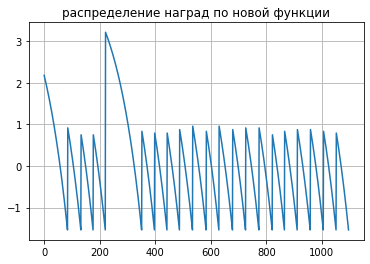

In [ ]:
plt.plot(processRewards(rewardsList),'-') # добавляем в график награды с учетом новой функции
ax = plt.gca()                            # текущие оси
ax.grid(True)  
ax = plt.title("распределение наград по новой функции")
# новое распределение наград даст лучшее отражение эффективности действий

## Игровой эпизод с последующей тренировкой сети




In [ ]:
statesList,upDownActionList,rewardsList,networkOutputList = generateEpisode(policyNetworkModel)   # Сгенерируем новый игровой эпизод:
# сыграли до 21 очка, проиграли, получили списки всех состояний среды(кадров), шагов агента, вознаграждений и предсказаний
 
print("Количество состояний среды = ", str(len(statesList)))                                       # выведем количество состояний среды(кадров) в игровом эпизоде
print("Форма состояний среды = ", str(statesList[0].shape))                                        # выведем форму для каждого состояния
print("Список наград  = ", str(len(rewardsList)))                                                  # выведем список наград в игровом эпизоде(включая нулевые)

Количество состояний среды =  1329
Форма состояний среды =  (80, 80)
Список наград  =  1329


### Готовлю данные для тренировки:

In [ ]:
x = np.array(statesList)                                          # зададим 'x' как массив состояний 
episodeReward = np.expand_dims(processRewards(rewardsList), 1)    # подобьем размер для входа в сетку
yTmp = np.array(upDownActionList)                                 # зададим 'y' как список движений вверх(1)/вниз(0)
yTrue = np.expand_dims(yTmp, 1)                                   # скорректируем форму под сетку
 
 
print("Форма наград за эпизод =", episodeReward.shape)            # выведем форму наград за эпизод
print("Форма состояний среды =", x.shape)                         # выведем форму состояний среды ('x' для нейросети)
print("Форма фактических движений =", yTrue.shape)                # выведем форму фактических движений ('y' для нейросети)

Форма наград за эпизод = (1329, 1)
Форма состояний среды = (1329, 80, 80)
Форма фактических движений = (1329, 1)


In [ ]:
episodeReward[:15]

array([[2.486204 ],
       [2.476163 ],
       [2.46602  ],
       [2.455775 ],
       [2.4454265],
       [2.4349735],
       [2.4244146],
       [2.4137492],
       [2.4029763],
       [2.3920941],
       [2.3811023],
       [2.3699996],
       [2.3587844],
       [2.3474562],
       [2.3360136]], dtype=float32)

In [ ]:
policyNetworkTrain.fit(x=[x, episodeReward], y=yTrue)     # "Скормим" модели новые 'x' и 'y'

Epoch 1/1
1329/1329 [==============================] - 0s 158us/step - loss: -4.7354e-04


###Серия игровых эпизодов, Затем предобработаем данные для нейросети:

In [ ]:
def generateEpisodeBatchesTraining(model, nBatches=10):   # подаем на вход заданное количество игровых серий

    env = gym.make('Pong-v0')                             # создаем игровую среду Pong
    batchStateList = []                                   # зададим серию списков состояний
    batchUpDownActionList = []                            # зададим серию списков движений
    batchRewardsList = []                                 # зададим серию списков наград
    batchNetworkOutputList = []                           # зададим серию списков из вероятности идти вверх
    for i in range(nBatches):                             # для каждой серии 
        statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(model) # сгенерируем игровой эпизод
        batchStateList.extend(statesList)                   # добавим список состояний в серию списков состояний
        batchNetworkOutputList.extend(networkOutputList)    # добавим список вероятностей в серию списков из вероятности идти вверх
        batchUpDownActionList.extend(upDownActionList)      # добавим список движений в серию списков движений
        batchRewardsList.extend(rewardsList)                # добавим список наград в серию списков наград
  
    episodeReward = np.expand_dims(processRewards(batchRewardsList), 1) # зададим награды и изменим форму массива с добавлением оси
    x = np.array(batchStateList)                          # сформируем массив из серии списков состояний в качестве 'x' для нейросети
    yTmp = np.array(batchUpDownActionList)                # зададим 'y' как серию из списков движений вверх(1)/вниз(0)
    yTrue = np.expand_dims(yTmp, 1)                       # подгоним форму 'y' массива с добавлением оси
    
    history = policyNetworkTrain.fit(x=[x,episodeReward], y=yTrue, epochs=5, verbose=0) # скормим нейросети серию 'x'ов и 'y'ов
    
    batchLoss = history.history['loss'][-1]
    
    return batchStateList, batchUpDownActionList, batchRewardsList, batchNetworkOutputList, batchLoss
    # функция вернёт серию списков состояний, серию списков движений, серию списков наград, серию списков из вероятности идти вверх

## Задание №1.Oбучение сети на серии игровых эпизодов(10,20,30):



In [ ]:
basket_winnings = []

def trainingTimes(trainingTimes):
  
    for training in range(trainingTimes): 
        statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
        basket_winnings.append(len(rr[rr > 0]))
        if training % 10 == 0:                                                   # через каждые 10 эпизодов
            policyNetworkModel.save("policyNetworkModel.h5")                     # сохраним модель в памяти
            policyNetworkModel.save("policyNetworkModel" + str(training)+".h5")  # и для удобства сохраним модель в памяти с количеством тренировок в названии
            with open('rewardsModelSimple.txt','a') as recordingRewards:         # также в текстовом файле будем вести записи с динамикой выигранных очков
                recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
                recordingRewards.write("\n")

    print("сумма выигранных очков на", trainingTimes, "тренировках =", sum(basket_winnings))

In [ ]:
trainingTimes(10)

сумма на 10 тренировках = 384


In [ ]:
trainingTimes(20)

сумма на 20 тренировках = 1024


In [ ]:
trainingTimes(30)

сумма на 30 тренировках = 1984


In [ ]:
"""
Вывод: во увеличению кол-ва выигранных очков, видно, что сеть обучается правильно.
количество очков увеличивается не линейно. Подкрепление работает
"""

## Задание №2:
### изменяю количество связей в Dense слое:

In [ ]:
"""
 в этом месте поломалось окружение. Я эту часть выполнял на следующий день. В пердидущий 1я часть работала, все норм было.
 перезапускал ноутбук. Перезапускал все ячейки. Увы((( Не победил. 
 Что предлагает сделать stackoverflow - не понял, увы
 При этом 2я часть задания выполнена в части написания новых архитектур.
 А запустить их не смог(
 Плиз примите в этом виде с оценкой, как принято в этом случае поступать в Унрверситете 
 Спасибо)
"""

In [ ]:
inputs = Input(shape=(80,80))                                                       

flattenedLayer = Flatten()(inputs)                                                  # в вектор
fullConnected = Dense(400, activation="relu", use_bias=False)(flattenedLayer)      
sigmoidOutput = Dense(1, activation="sigmoid", use_bias=False)(fullConnected)       
policyNetworkModel = Model(inputs=inputs, outputs=sigmoidOutput)                    

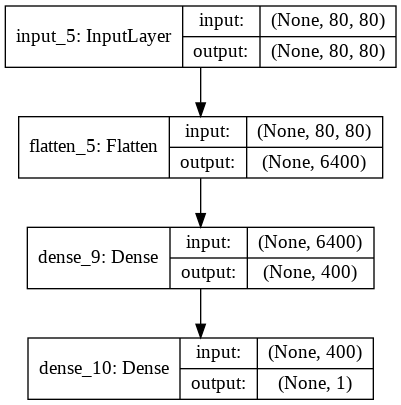

In [ ]:
plot_model(policyNetworkModel, show_shapes=True, show_layer_names=True)

In [ ]:
trainingTimes(3)

NameError: ignored

###Добавляю Dense слой:

In [ ]:
inputs = Input(shape=(80,80))                                                       

flattenedLayer = Flatten()(inputs)                                                  
fullConnected1 = Dense(200, activation="relu", use_bias=False)(flattenedLayer) 
fullConnected2 = Dense(400, activation="relu", use_bias=False)(fullConnected1)
sigmoidOutput = Dense(1, activation="sigmoid", use_bias=False)(fullConnected2) 

policyNetworkModel = Model(inputs=inputs, outputs=sigmoidOutput) 

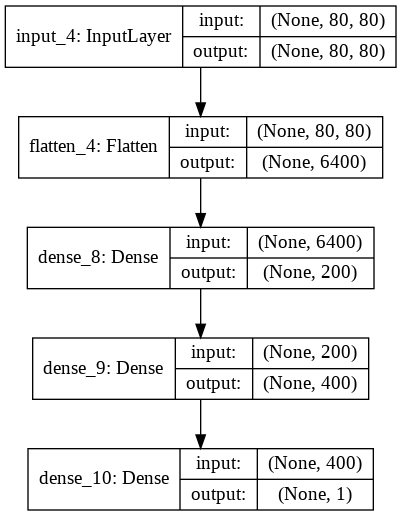

In [ ]:
plot_model(policyNetworkModel, show_shapes=True, show_layer_names=True)

##Добавляю Conv слой:

In [ ]:
inputs = Input(shape=(80, 80))                                                       

fullConnected1 = Reshape((80, 80, 1))(inputs)
fullConnected2 = Conv2D(4,(3, 3), padding="same", activation="relu")(fullConnected1)
flattenedLayer = Flatten()(fullConnected2)
fullConnected3 = Dense(200, activation="relu", use_bias=False)(flattenedLayer) 
fullConnected4 = Dense(400, activation="relu", use_bias=False)(fullConnected3)
sigmoidOutput = Dense(1, activation="sigmoid", use_bias=False)(fullConnected4)

policyNetworkModel = Model(inputs=inputs, outputs=sigmoidOutput)

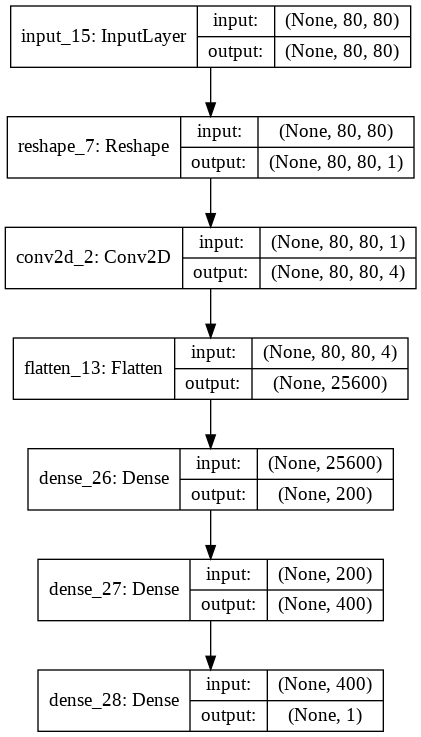

In [ ]:
plot_model(policyNetworkModel, show_shapes=True, show_layer_names=True)

In [ ]:
trainingTimes(3)

NameError: ignored